**Weekly petrol and diesel data in the UK**

- Please view this in a nbviewer, an circle icon on the top right of the notebook will direct you towards a more interactive notebook.

**References:**

- **Data:** https://www.gov.uk/government/statistical-data-sets/oil-and-petroleum-products-weekly-statistics


- **EDA in Time Series:** https://pawarbi.github.io/blog/forecasting/r/python/rpy2/altair/2020/04/21/timeseries-part1.html


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)

from statsmodels.graphics.tsaplots import quarter_plot
from statsmodels.tsa.stattools import adfuller


import plotly.graph_objects as go

from pylab import rcParams
rcParams['figure.figsize'] = 16, 10

## Loading the data and slight cleaning

In [2]:
data = pd.read_csv('CSV_180520.csv', sep=',', encoding='unicode_escape', header=2)
data.head()

,Date,ULSP,ULSD,ULSP.1,ULSD.1,ULSP.2,ULSD.2,Unnamed: 7,ULSD = Ultra low sulphur diesel,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,09/06/2003,74.59,76.77,45.82,45.82,17.5,17.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16/06/2003,74.47,76.69,45.82,45.82,17.5,17.5,NaN,ULSP and ULSD,NaN,NaN,NaN,NaN,NaN
2,23/06/2003,74.42,76.62,45.82,45.82,17.5,17.5,NaN,Duty rate per litre (£) from 7 March 2001,NaN,NaN,NaN,NaN,0.4582
3,30/06/2003,74.35,76.51,45.82,45.82,17.5,17.5,NaN,Duty rate per litre (£) from 1 October 2003,NaN,NaN,NaN,NaN,0.4710
4,07/07/2003,74.28,76.46,45.82,45.82,17.5,17.5,NaN,Duty rate per litre (£) from 7 December 2006,NaN,NaN,NaN,NaN,0.4835


In [3]:
# Cleaning some data

data = data.rename(columns={'ULSP':'petrol_pump_price', 'ULSD':'diesel_pump_price',
                     'ULSP.1':'petrol_duty_rate', 'ULSD.1':'diesel_duty_rate',
                    'ULSP.2':'petrol_vat_percent_rate', 'ULSD.2':'diesel_vat_percent_rate'})

data = data.iloc[:,0:7]

data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['dayofweek'] = data['Date'].dt.dayofweek
data['quarter'] = data['Date'].dt.quarter

data.set_index('Date', inplace=True)

In [4]:
data.head()

,petrol_pump_price,diesel_pump_price,petrol_duty_rate,diesel_duty_rate,petrol_vat_percent_rate,diesel_vat_percent_rate,Year,Month,dayofweek,quarter
Date,,,,,,,,,,
2003-06-09,74.59,76.77,45.82,45.82,17.5,17.5,2003,6,0,2
2003-06-16,74.47,76.69,45.82,45.82,17.5,17.5,2003,6,0,2
2003-06-23,74.42,76.62,45.82,45.82,17.5,17.5,2003,6,0,2
2003-06-30,74.35,76.51,45.82,45.82,17.5,17.5,2003,6,0,2
2003-07-07,74.28,76.46,45.82,45.82,17.5,17.5,2003,7,0,3


### Plotting of Petrol and Diseal pump price over time

In [5]:
def interactive_scatter_2(actual_df, actual_name, predicted_df, predicted_name,
                         title="", yaxis_title="",xaxis_title=""):
    '''
    actual_df: dataframe of actual values
    actual_name: Name to be given for actual legend
    
    predicted_df: dataframe of predicted values
    predicted_name: Name to be fiven for predicted legend
    
    title: Title for the graph
    '''
    
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=actual_df.index,y=actual_df, name=actual_name))
    
    fig.add_trace(go.Scatter(x=predicted_df.index, y=predicted_df, name=predicted_name))
    fig.update_layout(title=title,yaxis_title=yaxis_title, xaxis_title=xaxis_title)
    fig.show(render="png")

In [19]:
interactive_scatter_2(data['diesel_pump_price'],"Diesel",
                     data['petrol_pump_price'], "Petrol",
                     title='Petrol and Diesel pump price in pence/litre over time',
                     yaxis_title='Pence per litre',xaxis_title='Date')

- Petrol and Diseal pump price seems to show similar trend and shape. The reason for this could be the the duty rate and percent rate having similar values for both Petrol and diseal.


- Also, we can see that after February onwards the price for both seems to be decreasing, one of the factor for this could be due to the Covid-19 pandemic.

### Quarterly plot for all years

In [7]:
# Plot quarterly data with 2 columns and x amount of rows (depending on yearly data)

def plot_quarterly(df_year,data, name_col):
    
    '''
    
    df_year: This is the year column with just the year data.
    data: This is the whole dataset.
    name_col: This to decide which column to look into.
    
    This is just or subplot with 2 columns, could add new argument to increase, but have to change
    figsize and fontsize and y. Due to change of plotting.
    
    '''
    
    years_values = df_year.unique()
    total_plots = (len(years_values)//2) # to get the total number of subplots that we need

    f, axes = plt.subplots(total_plots,2,figsize=(14,50))
    f.suptitle('Quarterly plot for petrol_pump_price per year', fontsize=20, y=0.90)

    count = 0 # to select the years

    # Loops over figures and plots quartely plots for each year
    for i in range(total_plots):

        for j in range(2):

            #print(f'i: {i}, j: {j} and count: {count}')
            data[data.Year == years_values[count]].groupby('quarter')[name_col].plot(ax=axes[i,j])
            axes[i,j].legend(loc='best')
            count += 1

    plt.show()

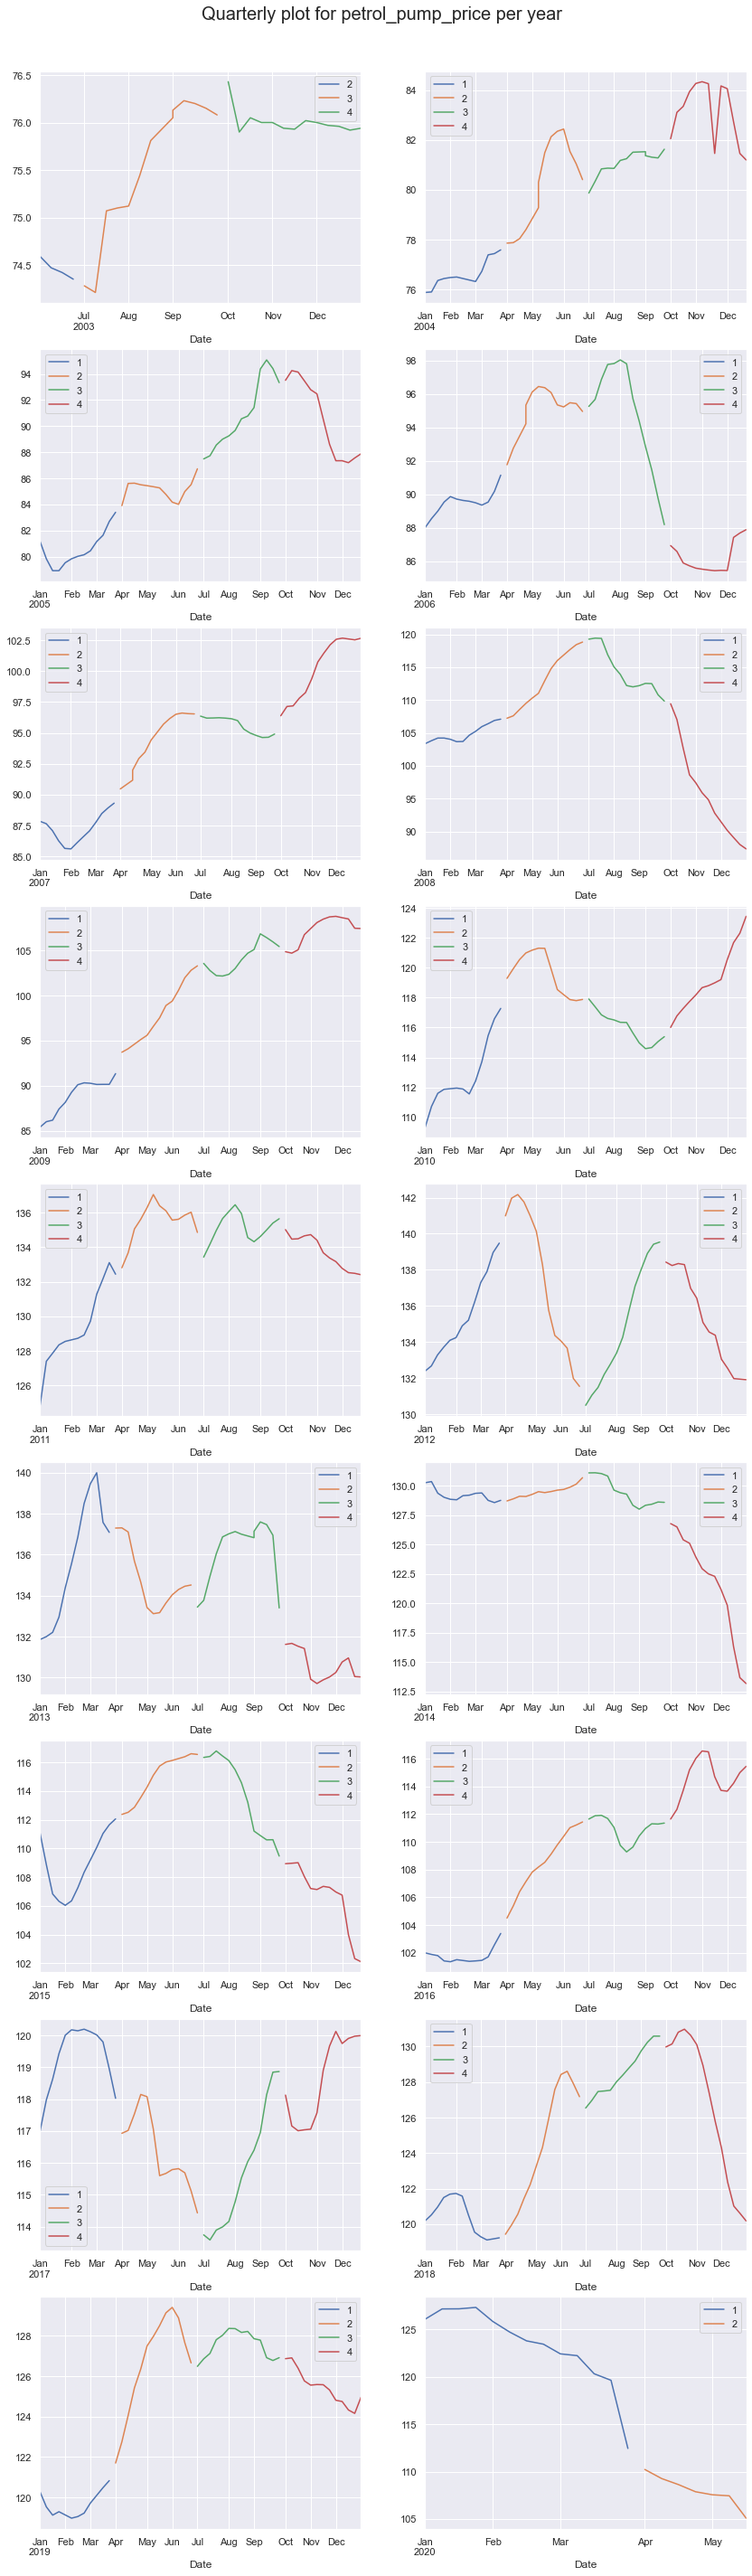

In [8]:
plot_quarterly(data.Year, data, 'petrol_pump_price')

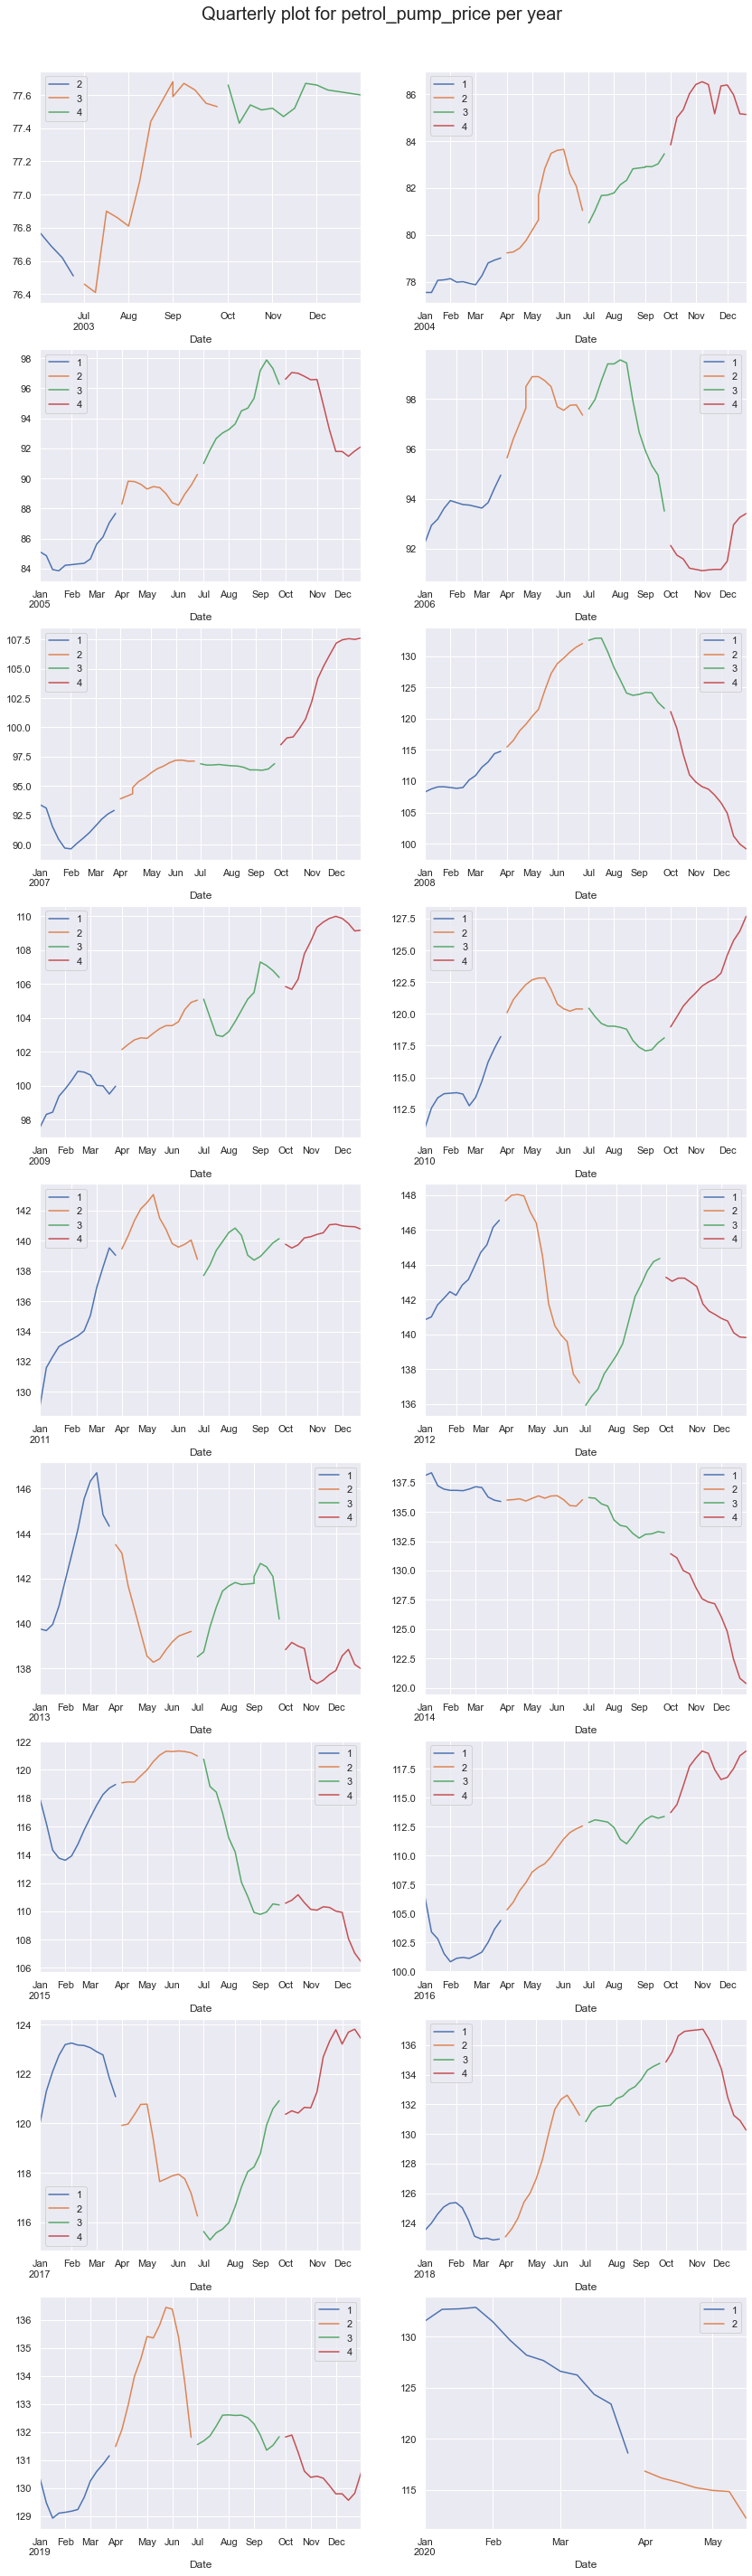

In [9]:
plot_quarterly(data.Year, data, 'diesel_pump_price')

### Viewing the distribution of petrol and diseal pump price

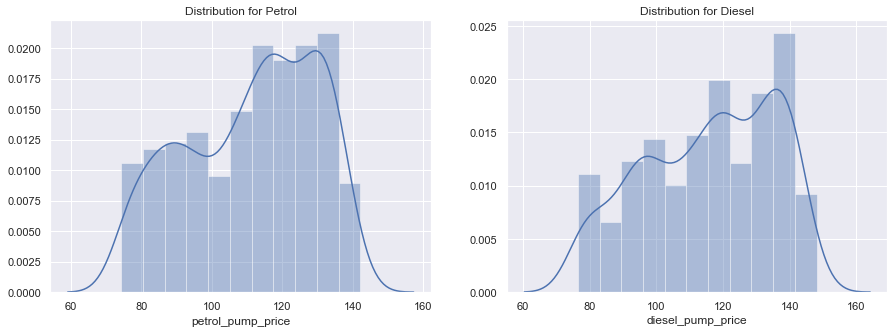

In [17]:
f, axes = plt.subplots(1,2, figsize=(15,5))
sns.distplot(data['petrol_pump_price'], ax = axes[0]).set_title('Distribution for Petrol')
sns.distplot(data['diesel_pump_price'], ax = axes[1]).set_title('Distribution for Diesel')
plt.show()

The distribution for petrol and diseal don't seem to have a normal/guassian distribution. Although it does look fairly ok. 

### Box plots for petrol and diseal for all years

In [11]:
fig = go.Figure()
fig.add_trace(go.Box(y=data['petrol_pump_price'], x=data.Year, marker_color = 'indianred'))
fig.update_layout(title='Boxplot for Petrol Pump price for each year',
                 yaxis_title='Pence per litre', xaxis_title='Date')
fig.show(render='png')

In [18]:
fig = go.Figure()
fig.add_trace(go.Box(y=data['diesel_pump_price'], x=data.Year, marker_color = 'lightseagreen'))
fig.update_layout(title='Boxplot for Diseal Pump price for each year',
                 yaxis_title='Pence per litre', xaxis_title='Date')
fig.show(render='png')

- We can see that both petrol and diseal both have outliers associated with them in some years. Although it would be a good notion towards removing outliers. However, most would say to only remove outliers if the data points are abnormal. Sometimes, the outlier could be real values whih needs to be investigated further, but it is not a good approach to drop them. Furthermore, this needs to be investigated further.

ref: https://www.researchgate.net/post/How_do_I_remove_outliers_from_time_series_data

In [13]:
# Correlation check
data.corr()[0:2].T

,petrol_pump_price,diesel_pump_price
petrol_pump_price,1.000000,0.989742
diesel_pump_price,0.989742,1.000000
petrol_duty_rate,0.866896,0.839370
diesel_duty_rate,0.866896,0.839370
petrol_vat_percent_rate,0.696958,0.671445
diesel_vat_percent_rate,0.696958,0.671445
Year,0.712111,0.694802
Month,0.009331,-0.002290
dayofweek,-0.049529,-0.052893
quarter,0.011921,-0.000983


### Checking for data integrity/quality

In [14]:
print('**Check for missing data**')
print(data.isna().sum())
print('\n')
print('**Check for unique dates**')
print(f'Unique dates: {data.index.nunique()}')

**Check for missing data**
petrol_pump_price          0
diesel_pump_price          0
petrol_duty_rate           0
diesel_duty_rate           0
petrol_vat_percent_rate    0
diesel_vat_percent_rate    0
Year                       0
Month                      0
dayofweek                  0
quarter                    0
dtype: int64


**Check for unique dates**
Unique dates: 885


In [15]:
len(data)

885

- There are no missing data and the dates all have unique values, which indicates a good sign. 

- However, upon further investigating the data, there seems to be an uneven frequency for the dates. Which is an issue that will be addressed later by the use of sampling and interpolation. But for now, we will keep the uneven frequency.